In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null

In [3]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [4]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

In [5]:
for i in glob.glob('/content/64x64/train_normal/train_normal_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/content/64x64/train_attack/train_attack_*.jpg', recursive=True):
    train_attack.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/content/64x64/test_normal/test_normal_*.jpg', recursive=True):
    test_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/content/64x64/test_attack/test_attack_*.jpg', recursive=True):
    test_attack.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

train_normal = np.stack(train_normal)
train_attack = np.stack(train_attack)
test_normal = np.stack(test_normal)
test_attack = np.stack(test_attack)

In [6]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack),

((1874, 64, 64), (1628, 64, 64), (271, 64, 64), (357, 64, 64))

In [7]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


train = np.vstack((train_normal, train_attack, vert_flip_train_attack, vert_flip_train_normal, hor_flip_train_attack, hor_flip_train_normal,rotate90l_train_attack, rotate90r_train_attack, rotate90r_train_normal, rotate90l_train_normal))

test = np.vstack((test_normal, test_attack, vert_flip_test_attack, vert_flip_test_normal, hor_flip_test_attack, hor_flip_test_normal,rotate90l_test_attack, rotate90r_test_attack, rotate90l_test_normal, rotate90r_test_normal))

In [ ]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_attack))
test = np.vstack((test_normal, test_attack))

In [41]:
train.shape, test.shape

((17510, 64, 64), (3140, 64, 64))

In [8]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

In [9]:
train.shape, test.shape

((17510, 64, 64, 1), (3140, 64, 64, 1))

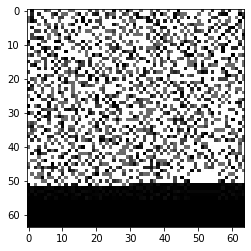

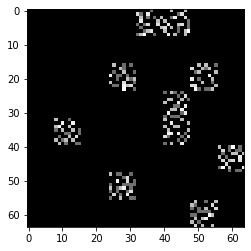

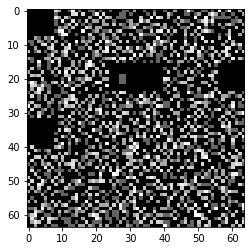

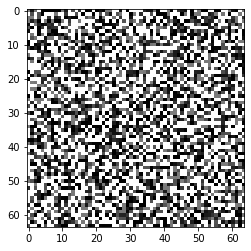

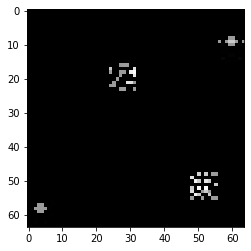

In [10]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [ ]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [11]:
## create the training and testing data labels
## run this cell if using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [12]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 17505       0       1
 17506       0       1
 17507       0       1
 17508       0       1
 17509       0       1
 
 [17510 rows x 2 columns],       attack  normal
 0          1       0
 1          1       0
 2          1       0
 3          1       0
 4          1       0
 ...      ...     ...
 3135       0       1
 3136       0       1
 3137       0       1
 3138       0       1
 3139       0       1
 
 [3140 rows x 2 columns])

In [13]:
## shuffle the data to prevent pattern recognition
train = sklearn.utils.shuffle(train, random_state = 7)
ytrain = sklearn.utils.shuffle(ytrain, random_state = 7)

test = sklearn.utils.shuffle(test, random_state = 7)
ytest = sklearn.utils.shuffle(ytest, random_state = 7)

In [14]:
cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(16, (3,3), padding="same", activation='relu', input_shape = (64,64,1)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 2
cnn.add(Convolution2D(32, (3,3), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 3
cnn.add(Convolution2D(64, (3,3), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 4
cnn.add(Convolution2D(128, (3,3), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(256, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.8))

## convolution 6
# cnn.add(Convolution2D(256, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (1,1)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         7

In [15]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 512, epochs = 200)
end = time.time()

os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/200
35/35 [==============================] - 5s 37ms/step - loss: 1.1242 - accuracy: 0.5199
Epoch 2/200
35/35 [==============================] - 1s 31ms/step - loss: 0.6894 - accuracy: 0.5426
Epoch 3/200
35/35 [==============================] - 1s 31ms/step - loss: 0.6845 - accuracy: 0.5486
Epoch 4/200
35/35 [==============================] - 1s 31ms/step - loss: 0.6861 - accuracy: 0.5586
Epoch 5/200
35/35 [==============================] - 1s 31ms/step - loss: 0.6763 - accuracy: 0.5679
Epoch 6/200
35/35 [==============================] - 1s 31ms/step - loss: 0.7380 - accuracy: 0.5544
Epoch 7/200
35/35 [==============================] - 1s 31ms/step - loss: 0.6819 - accuracy: 0.5573
Epoch 8/200
35/35 [==============================] - 1s 31ms/step - loss: 0.6727 - accuracy: 0.5854
Epoch 9/200
35/35 [==============================] - 1s 31ms/step - loss: 0.7248 - accuracy: 0.5372
Epoch 10/200
35/35 [==============================] - 1s 31ms/step - loss: 0.6862 - accuracy: 0.5440

dict_keys(['loss', 'accuracy'])


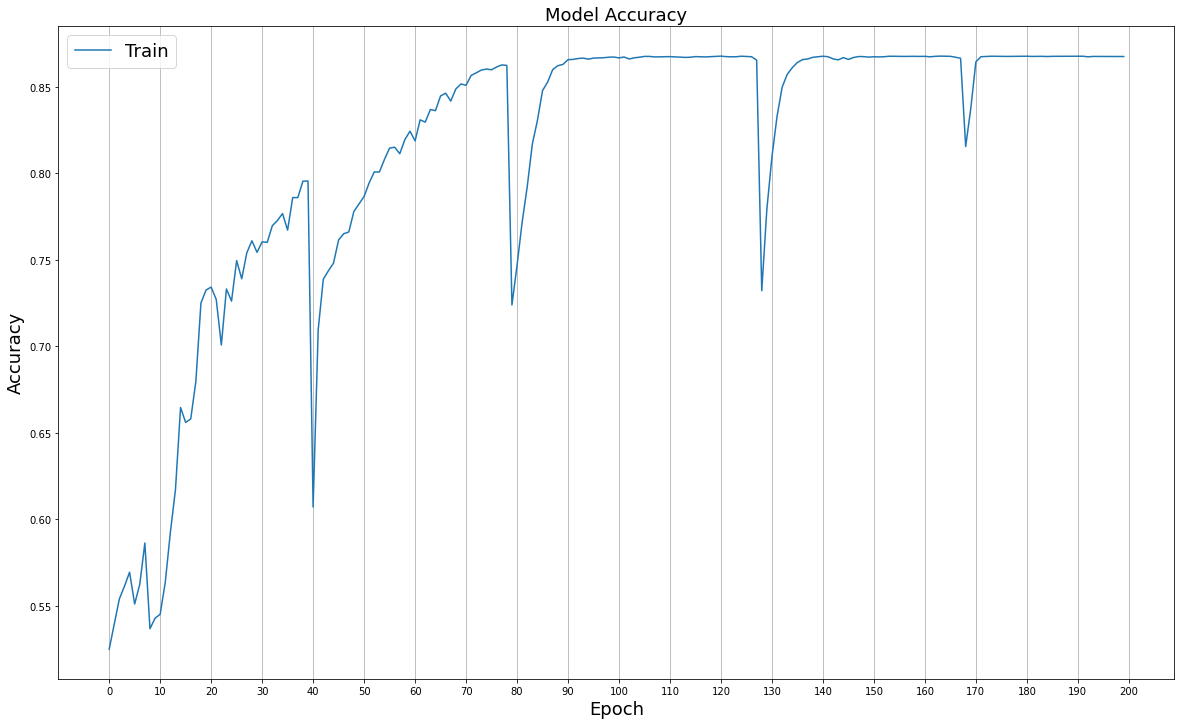

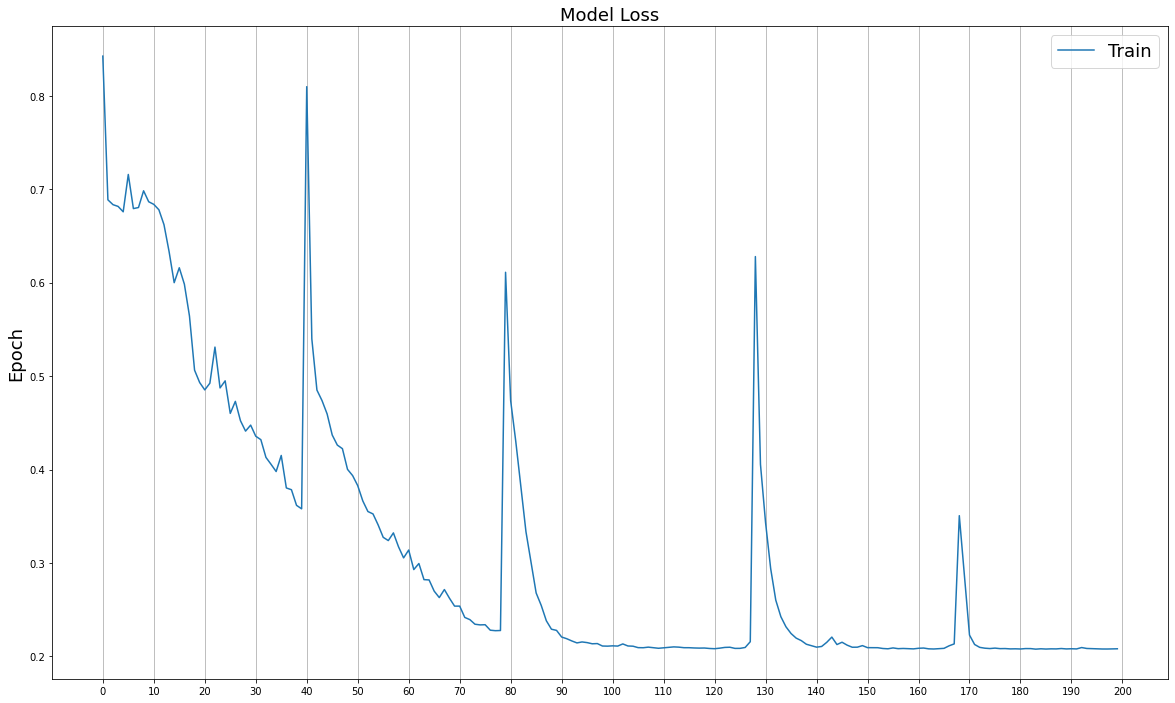

In [17]:
print(model_history.history.keys())

figure(figsize = (20,12))
plt.plot(model_history.history['accuracy'])
# plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 210, step = 10))
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

print()

figure(figsize = (20,12))
plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
plt.title('Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.ylabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 210, step = 10), )
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

In [18]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 200, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 1.5027	Accuracy = 71.43%


In [19]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.99825, 0.00217],
       [0.61082, 0.60779],
       [0.     , 1.     ],
       [0.00002, 0.99996],
       [0.05441, 0.96634],
       [0.     , 1.     ],
       [0.99993, 0.00012],
       [0.     , 1.     ],
       [0.     , 1.     ],
       [0.99997, 0.00004],
       [0.     , 1.     ],
       [0.54364, 0.46163],
       [0.     , 1.     ],
       [0.44066, 0.55961],
       [0.00018, 0.99961],
       [0.     , 1.     ],
       [1.     , 0.     ],
       [0.     , 1.     ],
       [0.44066, 0.55961],
       [0.     , 1.     ]], dtype=float32)

In [20]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(16, (3,3), padding="same", activation='relu', input_shape = (64,64,1)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(32, (3,3), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(64, (3,3), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(128, (3,3), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(256, (3,3), padding="same", activation='relu'))
    # cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 6
    # cnn.add(Convolution2D(512, (2,2), padding="same", activation='relu'))
    # cnn.add(MaxPooling2D(pool_size = (1,1)))
    # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(256, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 256, epochs = 200)

In [21]:
scores = cross_val_score(estimator = classifier, X = test, y = ytest, cv = 10, n_jobs = -1)
print(f'Model Cross Validation: \n{round(scores.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{scores}')

os.system('say "cross validation finished" ')

Model Cross Validation: 
75.1%
Model Cross Validation: 
[0.80255 0.73567 0.72611 0.7293  0.76433 0.80255 0.74841 0.66879 0.80573
 0.72293]


32512

In [24]:
!nvidia-smi


Tue May 11 14:42:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    35W /  70W |   3324MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------